In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import string, re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.util import ngrams

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
df = pd.read_csv('women_clothing_review.csv')

In [13]:
df = df.fillna('')

In [14]:
df['text'] = df['Title'].str.cat(df['Review Text'], sep=' ')

In [15]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'text'],
      dtype='object')

## Bag of Words Model

What is bag of words:

Bag of words model allows us to represent text as numerical feature vectors. The idea behind the bag-of-words model is:
1. Create a vocabulary of unique tokens. For example, words from the entire set of documents.
2. Construct a feature vector from each document that contains the counts of how often each word occurs in the particular document. 

### Clean Data

Before bag of words, we need to clean the data:

1. make all lower case
2. Remove punctuation, numbers, symbols, etc
3. Remove stop words, perhaps develop custom stop words list
4. Stemming/Lemmatization

In [16]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [17]:
data_clean = pd.DataFrame(df.text.apply(round1))
data_clean

,text
0,absolutely wonderful silky and sexy and comf...
1,love this dress its sooo pretty i happened ...
2,some major design flaws i had such high hopes ...
3,my favorite buy i love love love this jumpsuit...
4,flattering shirt this shirt is very flattering...
...,...
23481,great dress for many occasions i was very happ...
23482,wish it was made of cotton it reminds me of ma...
23483,cute but see through this fit well but the top...
23484,very cute dress perfect for summer parties and...


In [18]:
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [19]:
data_clean = pd.DataFrame(data_clean.text.apply(round2))

In [20]:
data_clean

,text
0,absolutely wonderful silky and sexy and comf...
1,love this dress its sooo pretty i happened ...
2,some major design flaws i had such high hopes ...
3,my favorite buy i love love love this jumpsuit...
4,flattering shirt this shirt is very flattering...
...,...
23481,great dress for many occasions i was very happ...
23482,wish it was made of cotton it reminds me of ma...
23483,cute but see through this fit well but the top...
23484,very cute dress perfect for summer parties and...


Stemming text

In [250]:
# from nltk.stem.porter import PorterStemmer

In [251]:
# porter = PorterStemmer()

# def stemming(text):
#     text = [porter.stem(w) for w in text]
#     return text
# round5 = lambda x: stemming(x)

In [252]:
# data_clean = pd.DataFrame(data_clean.text.apply(round5))

## Transforming Words into Feature Vectors

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [309]:
cv = CountVectorizer(stop_words='english')
# tokenize and build vocab
cv.fit(data_clean.text)
# encode document
data_cv = cv.transform(data_clean.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
print(data_cv.shape)
print(type(data_cv))

(23486, 19371)
<class 'scipy.sparse.csr.csr_matrix'>


In [315]:
# define a function to find the top20 unigrams:
def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    words_bag = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = words_bag.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

<AxesSubplot:title={'center':'Top 10 unigrams in review after removing stop words'}, xlabel='ReviewText'>

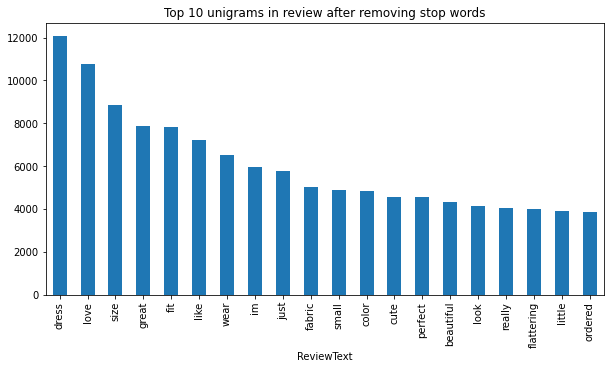

In [320]:
# visualize the top 20 unigrams:
pop_words = top_n_ngram(data_clean['text'], 20,1)
df = pd.DataFrame(pop_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,5))
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 10 unigrams in review after removing stop words')

<AxesSubplot:title={'center':'Top 10 unigrams in review after removing stop words'}, xlabel='ReviewText'>

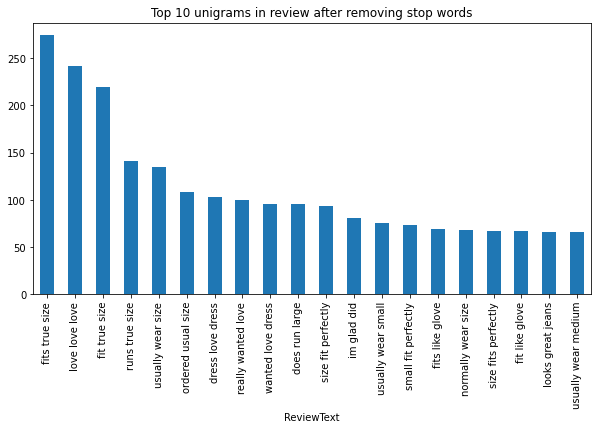

In [321]:
# visualize the top 20 3-grams:
pop_words = top_n_ngram(data_clean['text'], 20,3)
df = pd.DataFrame(pop_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,5))
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 10 unigrams in review after removing stop words')

In [23]:
tfidf = TfidfVectorizer(use_idf=True)
token = tfidf.fit_transform(df_['text'])
first_vector_tfidfvectorizer=token[0]
tfidf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf.get_feature_names(), columns=["tfidf"]) 
tfidf_df = tfidf_df.sort_values(by=["tfidf"],ascending=False)[:10]

In [24]:
token[:20000]

<20000x14679 sparse matrix of type '<class 'numpy.float64'>'
	with 851998 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.linear_model import LogisticRegression
X_train = token[:20000]
X_test = token[20000:]
y_train = df_['Recommended IND'][:20000].values
y_test = df_['Recommended IND'][20000:].values

In [26]:
lr = LogisticRegression(random_state=1)

lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [28]:
y_pred = lr.predict(X_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print()
print(f'ROC_AUC_SCORE is: {roc_auc_score(y_test, y_pred).round(3)}')

     0     1
0  338   273
1   90  2785

ROC_AUC_SCORE is: 0.761


## Sentment analysis

In [29]:
# !pip install TextBlob
from textblob import *

In [32]:
data_clean['polarity'] = data_clean['text'].map(lambda text: TextBlob(text).sentiment.polarity)

## Build a Logistic Regression model for comparison:

In [42]:
data_clean['recommend'] = df_['Recommended IND']
data_clean['rating'] = df_['Rating']
data_clean['Positive Feedback Count'] = df['Positive Feedback Count']
data_clean['Division Name'] = df['Division Name']
data_clean['Department Name'] = df['Department Name']

In [55]:
X = data_clean.drop(['recommend'], axis=1) 
y = data_clean['recommend']

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

,polarity,rating,Positive Feedback Count,Division Name,Department Name
0,0.633333,4,0,Initmates,Intimate
1,0.318750,5,4,General,Dresses
2,0.075813,3,0,General,Dresses
3,0.500000,5,0,General Petite,Bottoms
4,0.393750,5,6,General,Tops
...,...,...,...,...,...
23481,0.551905,5,0,General Petite,Dresses
23482,0.091667,3,0,General Petite,Tops
23483,0.425000,3,1,General Petite,Dresses
23484,0.409091,3,2,General,Dresses
